In [111]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader
from summaries import TensorboardSummary

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


# Model Load

In [119]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 128
PATH = '../tb_dir/cifar_exp/test_256bs_200epoch_baseline'
# PATH = '../tb_dir/cifar_exp/test_256bs_200epoch_layer3_1/3epoch'
model_path = os.path.join(PATH, 'saved_model.pt')

In [6]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [121]:
model = resnet_cifar(depth=args_depth, num_classes=num_classes)
model = model.cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
print('Successfully Load Model: ', os.path.basename(model_path))

Successfully Load Model:  saved_model.pt


In [69]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [122]:
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
val top1 Acc:0.8753


In [123]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

np.shape(true_labels)
np.shape(model_preds)
# pred_y = session.run(tf.argmax(y_, 1), feed_dict={X: test_x})
cm = confusion_matrix(model_preds, true_labels)
print(cm)

[[876   4  25  11   6   2   3   6  24  14]
 [  6 936   1   2   2   2   1   3  14  36]
 [ 24   1 824  23  31  10  18   8   6   6]
 [ 16   4  40 787  30 112  33  19   5   7]
 [  6   1  38  30 863  24  16  24   1   1]
 [  1   1  15  85  25 809  10  22   2   1]
 [  2   2  42  23  15   6 912   3   4   0]
 [  2   0   7  15  23  27   3 908   1   6]
 [ 51   8   4   8   3   2   1   2 930  21]
 [ 16  43   4  16   2   6   3   5  13 908]]


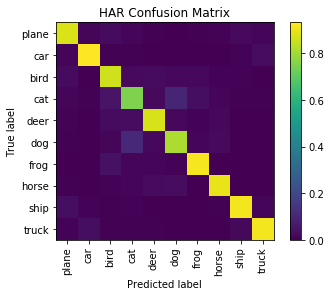

              precision    recall  f1-score   support

       plane       0.88      0.88      0.88       999
         car       0.93      0.93      0.93      1001
        bird       0.81      0.86      0.84       940
         cat       0.77      0.75      0.76      1029
        deer       0.88      0.88      0.88      1000
         dog       0.82      0.82      0.82       999
        frog       0.91      0.92      0.91       989
       horse       0.92      0.90      0.91      1014
        ship       0.93      0.92      0.92      1019
       truck       0.92      0.91      0.92      1010

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [118]:
plot_confusion_matrix(cm, labels_name, "HAR Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()
print(classification_report(model_preds, true_labels, target_names=labels_name))

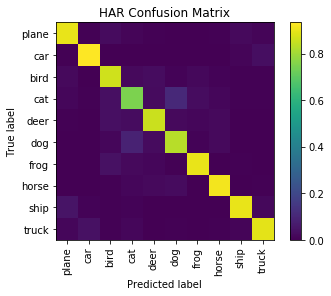

              precision    recall  f1-score   support

       plane       0.88      0.90      0.89       971
         car       0.94      0.93      0.93      1003
        bird       0.82      0.87      0.84       951
         cat       0.79      0.75      0.77      1053
        deer       0.86      0.86      0.86      1004
         dog       0.81      0.83      0.82       971
        frog       0.91      0.90      0.91      1009
       horse       0.91      0.92      0.91       992
        ship       0.93      0.90      0.92      1030
       truck       0.91      0.89      0.90      1016

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [124]:
plot_confusion_matrix(cm, labels_name, "HAR Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()
print(classification_report(model_preds, true_labels, target_names=labels_name))